# GEMS Lidar Usage Example

# Section 0: Establishing a connection
This code block contains all the imports needed for this notebook and establishes a session with the API used for all calls.
It also defines some variables that are calculated in section 1 so that users can skip to later sections without running those blocks.

## Set up an HTTP client using Python's request library
We use a `Session` object to store our API key and automatically include it in the header for each request.

Note that we have a `api_key.py` file in the Exchange-Notebooks directory. The file contains only the below line.
```
api_key = 'SECRET'
```

In [1]:
# Imports used in this notebook
import pandas as pd
# pd.options.display.max_colwidth = 50
import rasterio
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from requests import Session
import sys
sys.path.append('..')
from api_key import key

# Establish session with API server
s = Session()
s.headers.update({'apikey': key})

# Define the base of the mn-lidar-2010 dataset API URL
lidar_url = 'https://exchange-1.gems.msi.umn.edu/elevation/v2/mn-lidar-2010'

# Layer and object IDs that can be obtained from the commands in section 1, or from the documentation
bbox = {'bbox':'-93.76609,46.17284,-93.75106,46.164812'}
dem_layer_id = 1
dem_object_id = 2
dsm_layer_id = 7
dsm_object_id = 8
slope_layer_id = 9
slope_object_id = 10

# Section 1: Obtaining layer/object IDs
## List the layers available for a dataset on the elevation API
The mn-lidar-2010 dataset has three layers; the Digital Elevation model (DEM), Digital Surface Model (DSM), and percent slope derived from the DEM.

In [2]:
# List the layers on the mn-lidar-2010 dataset
# This endpoint returns metadata only, use the object endpoint to access raster data
res = s.get(f'{lidar_url}/layer')
layer_df = pd.json_normalize(res.json())
display(layer_df)

,name,units,description,discrete,id
0,Lidar DEM,meter,Bare earth digital elevation model (1m resolut...,False,295
1,Lidar DSM,meter,Digital surface model (highest elevation for a...,False,296
2,Lidar derived slope,percent,Percent slope derived from lidar collected in ...,False,297


## Attributes such as layer IDs can be access using pandas .loc

In [3]:
dem_layer_id = layer_df['id'].loc[layer_df['name'] == 'Lidar DEM'].item()
dsm_layer_id = layer_df['id'].loc[layer_df['name'] == 'Lidar DSM'].item()
slope_layer_id = layer_df['id'].loc[layer_df['name'] == 'Lidar derived slope'].item()

dem_description = layer_df['description'].loc[layer_df['name'] == 'Lidar DEM'].item()
dsm_description = layer_df['description'].loc[layer_df['name'] == 'Lidar DSM'].item()
slope_description = layer_df['description'].loc[layer_df['name'] == 'Lidar derived slope'].item()

print('DEM layer ID:', dem_layer_id)
print('DEM description:', dem_description)

print('DSM layer ID:', dsm_layer_id)
print('DSM description:', dsm_description)

print('Slope layer ID:', slope_layer_id)
print('Slope description:', slope_description)

DEM layer ID: 295
DEM description: Bare earth digital elevation model (1m resolution) derived from lidar collected in Minnesota from 2008 to 2012.
DSM layer ID: 296
DSM description: Digital surface model (highest elevation for a given point, e.g., the top of trees or buildings) derived from lidar collected in Minnesota from 2008 to 2012.
Slope layer ID: 297
Slope description: Percent slope derived from lidar collected in Minnesota from 2008 to 2012.


## List the object IDs available for a dataset on the elevation API
The DEM layer has one object which is a statewide 1m raster of bare earth elevation (i.e., excluding buildings, trees, and other surface features).
The DSM layer has one object which is a statewide 1m raster of the elevation of the highest surface feature (i.e., building roofs, tree tops, or the ground if there are no surface features).
The units of both objects are meters above mean sea level in the NAVD88 vertical datum.

In [4]:
# To return a list of object IDs associated with a dataset you must specify a bounding box
# While a bounding box is required, it will return the same results for the entire extent of the dataset
# It does not need to match your area of interest if they are both within the extent of the dataset
# Define bounding box by string of "upper left lon, lat, bottom right lon, lat" in decimal degrees

res = s.get(f'{lidar_url}/object/search', params=bbox)
objects_df = pd.json_normalize(res.json())
display(objects_df)

,id,grid_id,t_ranges,t_key,t_description,name,units,description,layer_id
0,187361,6,"[{'begin': None, 'end': None}]",None,None,Lidar DEM,meter,Bare earth digital elevation model (1m resolut...,295
1,187363,6,"[{'begin': None, 'end': None}]",None,None,Lidar derived slope,percent,Percent slope derived from lidar collected in ...,297
2,187362,6,"[{'begin': None, 'end': None}]",None,None,Lidar DSM,meter,Digital surface model (highest elevation for a...,296


## Object IDs can be accessed similarly to layer IDs
Alternatively, you may find object IDs in the documentation. Object and layer IDs are permanent and will always refer to the same object/layer on a dataset URL. While the ID is permanently reserved, the object/layer may be removed if it is deprecated.

In [5]:
dem_object_id = objects_df['id'].loc[objects_df['layer_id'] == dem_layer_id].item()
dsm_object_id = objects_df['id'].loc[objects_df['layer_id'] == dsm_layer_id].item()
slope_object_id = objects_df['id'].loc[objects_df['layer_id'] == slope_layer_id].item()

# Grid level refers to the GEMS grid resolution, a value from 0 to 6, where 0 corresponds to 36km and 6 corresponds to 1m resolution.
dem_grid_level = objects_df['grid_id'].loc[objects_df['layer_id'] == dem_layer_id].item()
dsm_grid_level = objects_df['grid_id'].loc[objects_df['layer_id'] == dsm_layer_id].item()
slope_grid_level = objects_df['grid_id'].loc[objects_df['layer_id'] == slope_layer_id].item()

print('DEM object ID:', dem_object_id)
print('DEM grid level:', dem_grid_level)

print('DSM object ID:', dsm_object_id)
print('DSM grid level:', dsm_grid_level)

print('Slope object ID:', slope_object_id)
print('Slope grid level:', slope_grid_level)

DEM object ID: 187361
DEM grid level: 6
DSM object ID: 187362
DSM grid level: 6
Slope object ID: 187363
Slope grid level: 6


# Section 2: Save locally, visualize, and calculate statistics on a layer
Once you have determined the object ID of the data you are interested in, you can query the API for values in that dataset.
The examples here use the DEM layer, but they also apply to the DSM and Slope layers, simply change the object_id in the URL.

## Save a subset of the DEM within a bounding box to a local file

In [6]:
# Define bounding box by string of "upper left lon, lat, bottom right lon, lat" in decimal degrees
# Maximum area of response is 51.91 sq miles / 134.46 sq km
bbox = {'bbox':'-93.76609,46.17284,-93.75106,46.164812'}

res = s.get(f'{lidar_url}/object/{dem_object_id}/raster', params=bbox)
# out_path = 'C:/path/to/dem_subset.tif' # Change to a local path
out_path = 'dem_subset.tif' # Change to a local path

with rasterio.MemoryFile(res.content) as memfile:
    with memfile.open() as raster:
        with rasterio.open(out_path, 'w', **raster.profile) as dst:
            dst.write(raster.read(1), 1) # Read the first band (DEM data are single band) of the raster and write to first band of file

## Get the elevation at a single point
Here we query the DEM layer (object ID 2) for elevation at the coordinates -93.76609, 46.17284

In [7]:
# Note that the order is lat, lon, which is reversed from the order used to define the bounding box
lat, lon = 46.17284, -93.76609

res = s.get(f'{lidar_url}/object/{dem_object_id}/point?lat={lat}&lon={lon}')
elevation = res.json()
print('Elevation in meters:', round(elevation['value'],2))

Elevation in meters: 383.47


## Visualize a subset of the DEM
Here we demonstrate a continuous color bar visualization.

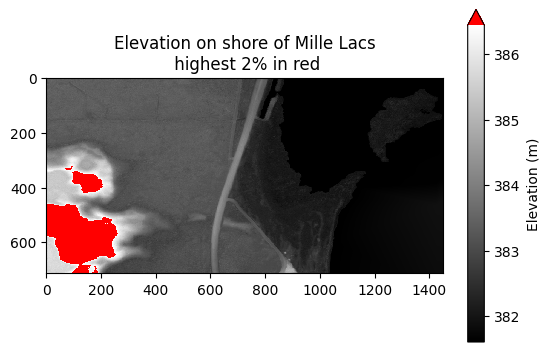

In [8]:
res = s.get(f'{lidar_url}/object/{dem_object_id}/raster', params=bbox)

with rasterio.MemoryFile(res.content) as memfile:
    with memfile.open() as dataset:
        dem = dataset.read(1) # Read the first and only band of the DEM dataset to an array for processing and visualization

        palette = plt.cm.gray.copy() # import a pre-made matplotlib color palette
        palette.set_over('red', 1.0) # color values over a range defined below red. set_under is also available
        palette.set_bad('blue', 0.0) # color 'bad' values (those defined by a mask below) as blue, but set opacity to 0.0 so they are transparent

        # Values returned from the API will likely have a small nodata border
        # These values must be masked otherwise the minimum color bar value will be the nodata value
        dem = np.ma.masked_where(dem == dataset.nodata, dem)

        plt.imshow(dem,
                   interpolation='none',
                   cmap=palette,
                   norm=colors.Normalize(vmin=dem.min(), vmax=(dem.max()*0.98))) # Define the color bar max as 98% of the max value to highlight the highest area
        plt.grid(False)
        plt.title('Elevation on shore of Mille Lacs\n highest 2% in red')
        plt.colorbar(label='Elevation (m)', extend='max', spacing='proportional', shrink=0.9)

    plt.show()

## Calculate statistics within a bounding box
Returns cell count, sum, mean, standard deviation, minimum, and maximum. Not all statistics will be relevant for all datasets, but all are calculated.

In [9]:
res = s.get(f'{lidar_url}/object/{dem_object_id}/stats', params=bbox)
bbox_stats = res.json()
display(pd.json_normalize(bbox_stats))

,count,sum,mean,stddev,min,max
0,1035195,3.964727e+08,382.993247,1.706297,381.606995,394.327911


## Calculate statistics within a polygon

In [10]:
# Define or import a geoJSON file
aoi = {"type": "Polygon", "coordinates":
    [[[-94.459905897999988, 45.318656823000026],
      [-94.460089729999936, 45.316738579000059],
      [-94.457336250999958, 45.31665066000005],
      [-94.457496103999972, 45.318556914000055],
      [-94.459905897999988, 45.318656823000026]]]}

res = s.post(f'{lidar_url}/object/{dem_object_id}/stats', json=aoi)
aoi_stats = res.json()
display(pd.json_normalize(aoi_stats))

# or access the mean directly
print('Elevation mean:', round(aoi_stats['mean'], 2))

,count,sum,mean,stddev,min,max
0,42954,1.573791e+07,366.389919,0.7082,364.311798,367.853088


Elevation mean: 366.39


# Section 3: Analyzing multiple arrays
In this section we get create arrays of raster values from both the DEM and DSM layers and compare them to calculate the height of buildings and trees.

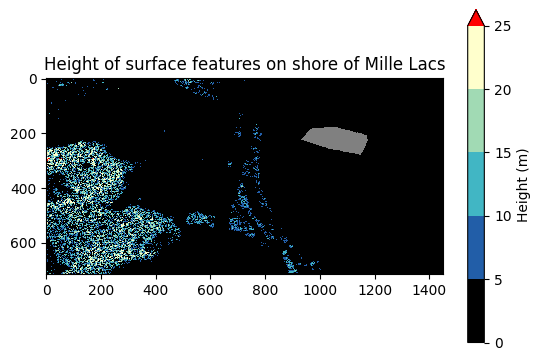

In [11]:
dem_res = s.get(f'{lidar_url}/object/{dem_object_id}/raster', params=bbox)
with rasterio.MemoryFile(dem_res.content) as dem_memfile:
    with dem_memfile.open() as dem_dataset:
        dem = dem_dataset.read(1)
        dem = np.ma.masked_where(dem == dem_dataset.nodata, dem)

dsm_res = s.get(f'{lidar_url}/object/{dsm_object_id}/raster', params=bbox)
with rasterio.MemoryFile(dsm_res.content) as dsm_memfile:
    with dsm_memfile.open() as dsm_dataset:
        dsm = dsm_dataset.read(1)
        dsm = np.ma.masked_where(dsm == dsm_dataset.nodata, dsm)

heights = dsm - dem

cmap = (colors.ListedColormap(['black', '#225ea8', '#41b6c4', '#a1dab4', '#ffffcc', 'red']))
bounds = [0, 5, 10, 15, 20, 25]
norm = colors.BoundaryNorm(bounds, cmap.N, extend='max')

cmap.set_bad('grey', 1.0)

plt.imshow(heights,
           interpolation='none',
           cmap=cmap,
           norm=norm)
plt.grid(False)
plt.title('Height of surface features on shore of Mille Lacs')
plt.colorbar(label='Height (m)', spacing='proportional', shrink=0.9)

plt.show()

In [12]:
out_path = 'surface_heights.tif' # Change to a local path
with rasterio.MemoryFile(dem_res.content) as dem_memfile:
    with dem_memfile.open() as dem_dataset:
        with rasterio.open(out_path, 'w', **dem_dataset.profile) as dst:
            dst.write(heights, 1)